# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [1]:
import datetime
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 100)
pd.options.mode.chained_assignment = None

sns.set(rc={"figure.figsize": (12, 8)})

warnings.filterwarnings("ignore")

## Подготовка

In [3]:
try:
    df_raw = pd.read_csv("/datasets/taxi.csv", index_col="datetime", parse_dates=True)
except FileNotFoundError:
    df_raw = pd.read_csv("./taxi.csv", index_col="datetime", parse_dates=True)

In [4]:
df_raw.head(10)

Данные загрузились корректно, видно, что интервал временного ряда составляет 10 минут. Согласно условниям нашей задачи, необходимо привести данные к часовым

In [5]:
df_raw.info()

In [6]:
pd.DataFrame(df_raw.index).diff(periods=1)["datetime"].dropna().unique()

In [7]:
df_raw.isna().sum()

Нам доступны данные за полгода, с начала марта до конца августа 2018. В данных нетпропущенных интервалов и пустых значений.

In [8]:
df_raw.describe()

In [9]:
df_raw[df_raw["num_orders"] > 100]

In [10]:
df_raw[
    df_raw["num_orders"]
    > (df_raw["num_orders"].mean() + 3 * df_raw["num_orders"].std())
]

In [11]:
(df_raw["num_orders"].max() - df_raw["num_orders"].mean()) / df_raw["num_orders"].std()

In [12]:
df_raw.loc[
    (df_raw.index.time < datetime.time(3, 0))
    & (df_raw.index.time > datetime.time(1, 0))
    & (df_raw["num_orders"] < 100)
].mean()

Количество вызовов такси ваотируется от 0 до 119 со средним значением 14, это выглядит не очень правдоподобно: максимальные значения отстаят от среднего на 11 стандартных отклонений. К тому же максимальные количества вызовов достигаются дважды и оба раза в 2 часа ночи, что странно. Это слишком похоже на ошибку в данных. Но, поскольку нас интересуют часовики, они естественным образом сгладят эти выбросы, с учётом того, что их не много.

Если взять среднее по интервалам в окрестностях 2:00, то оно оказывается равным 17,45, что несколько выше среднего по все выборке, что тоже вызывает удивление. Может время задано по UTC, а события в зоне +6, скажем?

Данные в исходной выборке представлены 10-минутными интервалами, преоборазуем данные в часовики. 

In [13]:
df = df_raw.resample("1H").sum()

In [14]:
df.sort_index(inplace=True)

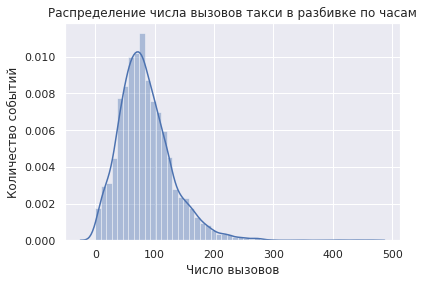

In [15]:
sns.distplot(df).set(
    title="Распределение числа вызовов такси в разбивке по часам",
    xlabel="Число вызовов",
    ylabel="Количество событий",
);

Данные представлены за полгода: с марта до августа 2018. Явные пропуски в данных отсутствуют 

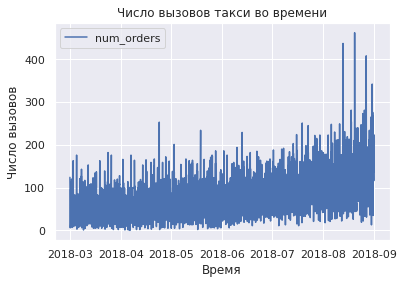

In [16]:
sns.lineplot(data=df).set(
    title="Число вызовов такси во времени", xlabel="Время", ylabel="Число вызовов"
);

Из сырых данных понятно не очень много: данные сильн зашумлены, но кажется, что имеет место нарастающий тренд. Это не удивительно, с учётом того, что коэффициент вариации достигает 53%

In [17]:
df.std() / df.mean()

Проверим нашу догадку:

In [18]:
test = adfuller(df)
print(f"adf: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Critical values:  {test[4]}")
if test[0] > test[4]["1%"]:
    print("ряд не стационарен")
else:
    print("ряд стационарен")

Как и следовало ожидать, тест показывает, что ряд стационарен.

Проверим, как себя ведёт разность первого порядка.

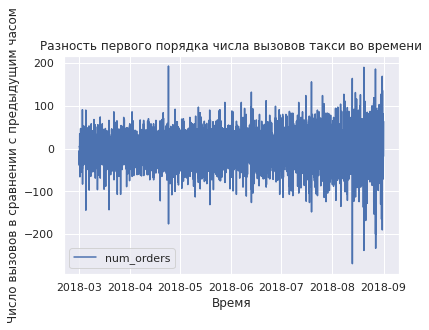

In [19]:
df_delta_1 = df.diff(periods=1).dropna()
sns.lineplot(data=df_delta_1).set(
    title="Разность первого порядка числа вызовов такси во времени",
    xlabel="Время",
    ylabel="Число вызовов в сравнении с предыдущим часом",
);

In [20]:
test = adfuller(df_delta_1)
print(f"adf: {test[0]}")
print(f"p-value: {test[1]}")
print(f"Critical values:  {test[4]}")
if test[0] > test[4]["5%"]:
    print("ряд не стационарен")
else:
    print("ряд стационарен")

Очевидно, полученный ряд стационарен. Таким образом наш временной ряд оказался интегрированным рядом первого порядка.

Декомпозируем временной ряд и посмотрим на его трендовую и сезонную составляющие

In [21]:
decomposed = seasonal_decompose(df)

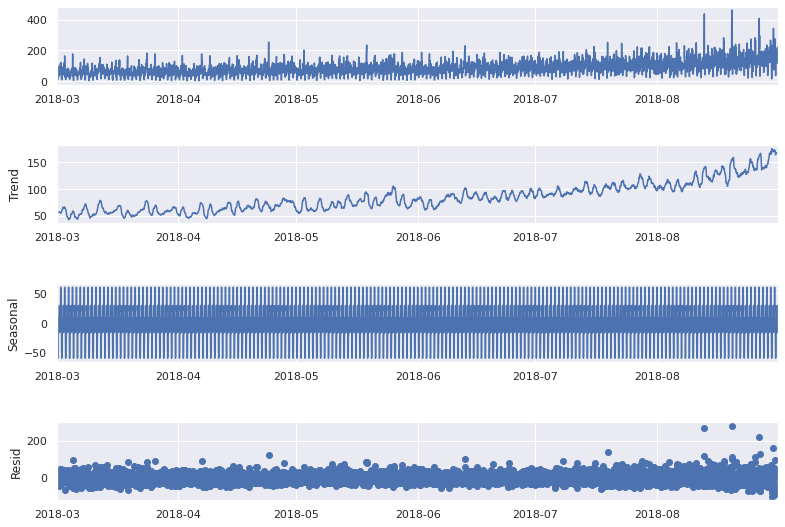

In [22]:
fig = decomposed.plot()
fig.set_size_inches(12, 8);

Рассмотрим графики компоненты более детально. 

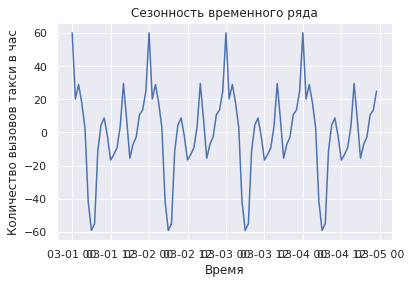

In [23]:
sns.lineplot(
    data=decomposed.seasonal[decomposed.seasonal.index < datetime.datetime(2018, 3, 5)]
).set(
    title="Сезонность временного ряда",
    xlabel="Время",
    ylabel="Количество вызовов такси в час",
);

Очевидно, сезонность в нашем ряде имеет суточный характер с пиком в районе полуночи и провалом в окрестности 6:00

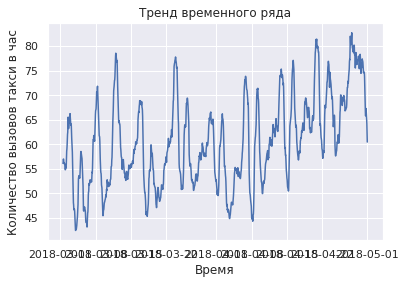

In [24]:
sns.lineplot(
    data=decomposed.trend[decomposed.trend.index < datetime.datetime(2018, 5, 1)]
).set(
    title="Тренд временного ряда",
    xlabel="Время",
    ylabel="Количество вызовов такси в час",
);

Тренд также имеет колебательный характер с плавным нарастанием. Но характер колебаний тренда вызывает удивление: 9 в месяц и 18 за 2 месяца. Условный период - 3,(3) дня. Возможно, это как-то связано расписанием полётов.

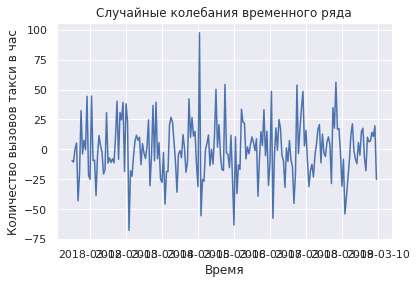

In [25]:
sns.lineplot(
    data=decomposed.resid[decomposed.resid.index < datetime.datetime(2018, 3, 10)]
).set(
    title="Случайные колебания временного ряда",
    xlabel="Время",
    ylabel="Количество вызовов такси в час",
);

Посмотрим, насколько случайны эти случайные остатки

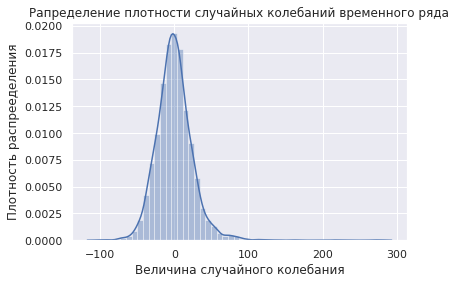

In [26]:
sns.distplot(decomposed.resid.dropna()).set(
    title="Рапределение плотности случайных колебаний временного ряда",
    xlabel="Величина случайного колебания",
    ylabel="Плотность распрееделения",
);

Распределение плотности случайных колебаний ряда весьма напоминает гауссовскую кривую, хотя и на глаз более "острая". Да и форма колокола не вполне симметрична: правый хвост заметно длиннее левого, что также даёт свой вклад в повышательный тренд (в широком смысле этого слова) нашего ряда

In [27]:
jb_test = jarque_bera(decomposed.resid.dropna())
a = np.array([jb_test]).ravel()
pd.DataFrame([a], columns=["JB", "p-value", "skew", "kurtosis"])

Тест Харке-Бера подтверждает: наша кривая не вполне симметрична (коэффициент симметрии $S$ равен 1,28, а не 0) и слишком "острая" (коэффициент эксцесса $K$ равен 12,85, а не 3) 

### Вывод

Мы провели первичный анализ данных. Данные оказались за полгода, мы привели их к часовикам и исследовали на стационарность. Ряд оказался интегрированным первого порядка. Эта информация нам пригодится в дальнейшем. 

Кроме того были выявлены колебания тренда с периодичностью 3,3 суток и суточная сезонность. Случайные колебания носят "почти" гауссов вид, хотя и не проходят тест Харке-Бера.

## Построение вспомогательных признаков

Для анализа временного ряда будем использовать номер часа (это должно иметь значение для загрузки такси), день недели и месяц, также добавим отстающие значения и скользящую среднюю. Помимо простой скользящей средней (SMA), хочется попробовать экспоненциальную скользящую среднюю, которая может показать лучшие результаты, если потребуется брать большие периоды усреднения  

In [28]:
def make_features(df, max_lag, average_length):
    data = df.copy()
    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day

    for lag in range(1, max_lag + 1):
        data[f"lag_{lag}"] = data["num_orders"].shift(lag)
    data["sma"] = data["num_orders"].shift().rolling(average_length).mean()
    data["ema"] = data["num_orders"].shift().ewm(span=average_length).mean()

    data = data.dropna()
    return data

Создадим ещё одну параметризованную функцию, которая принимает датафрейм и параметры сдвига и сглаживания и возвращает готовые тренировочные и тестовые наборы. Будет полезно для подбора параметров

In [29]:
def get_train_test(df_in, max_lag, average_length):
    df = make_features(df_in, max_lag, average_length)
    X = df.drop(["num_orders"], axis=1)
    y = df["num_orders"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, shuffle=False
    )
    return X_train, X_test, y_train, y_test

### Вывод

Мы написали пару функций, которые будут полезны при подборе оптимальных параметров  

## Обучение модели

Прежде, чем обучать нашу модель, определим значение среднеквадратичного отклонения на "наивных" моделях: константной (медиане) и основанной на предыдущих значениях (тоже в каком-то смысле "константной": она исходи из того, что предыдущее значение повторится). Для вычисления этих значений нам понадобится множество целевых признаков на тренеровочные и тестовые.

In [30]:
X_train, X_test, y_train, y_test = get_train_test(df, 24, 24)

In [31]:
pred_median = [y_train.median()] * y_test.shape[0]
pred_previous = y_test.shift(fill_value=y_test.iloc[-1])

In [32]:
print(f"RMSE of constant model: {mean_squared_error(y_test, pred_median)}")
print(f"RMSE of previous model: {mean_squared_error(y_test, pred_previous)}")

Эти модели ни куда не годятся учётом того, что наша задача в построении модели со среднеквадратичной ошибкой лучше 48.

Таким образом, мы получили ориентиры для оценки качества нашей будущей модели:

In [33]:
model = LinearRegression()

In [34]:
model.fit(X_train, y_train);

In [35]:
pred = model.predict(X_test)
print(f"RMSE of linear regression on test: {mean_squared_error(y_test, pred)**.5}")

Наша модель вписалась в требования точности даже без подбора параметров. Но не зря же мы писали функцию!

In [36]:
%%time

best_rmse = 1e10
best_lag = -1
best_ma = -1
lr_pred = None

for lag in range(70, 24 * 10 // 3 + 1):
    for ma in range(70, 24 * 10 // 3 + 1):
        X_train, X_test, y_train, y_test = get_train_test(df, lag, ma)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, pred) ** 0.5
        if rmse < best_rmse:
            best_rmse = rmse
            best_ma = ma
            best_lag = lag
            lr_pred = pred
print(f"Best RMSE: {best_rmse} on lag={best_lag} and ma={best_ma}")

## ARIMA

Многие аналитики используют для прогнозирования временных рядов модель ARIMA (autoregressive integrated moving average) или модель Бокса—Дженкинса, которая также реализована в библиотеке statsmodels. Посмотрим, на что она способна. 

Модель зависит от 3 параметров, $p$, $q$ и $d$. $d$ определяет порядок интегрированного ряда. Поскольку наш тест показал, что уже исходный ряд является стационарным, он является интегрированным рядом нулевого порядка, т.е. $d=0$. Т.е. в нашем случае мф получаем модель ARMA для стационарного ряда.

Рассмотрим оставшиеся параметры: $p$ отвечает за авторегрессионную составляющую модели (AR), его величину можно определить с помощью $pacf$ (частичной авторегрессионной функции), а $q$ - за скользящуюу среднюю (MA). Её мы будеи определять по автокорреляционной функции $acf$.

Построим автокоррелограммы.

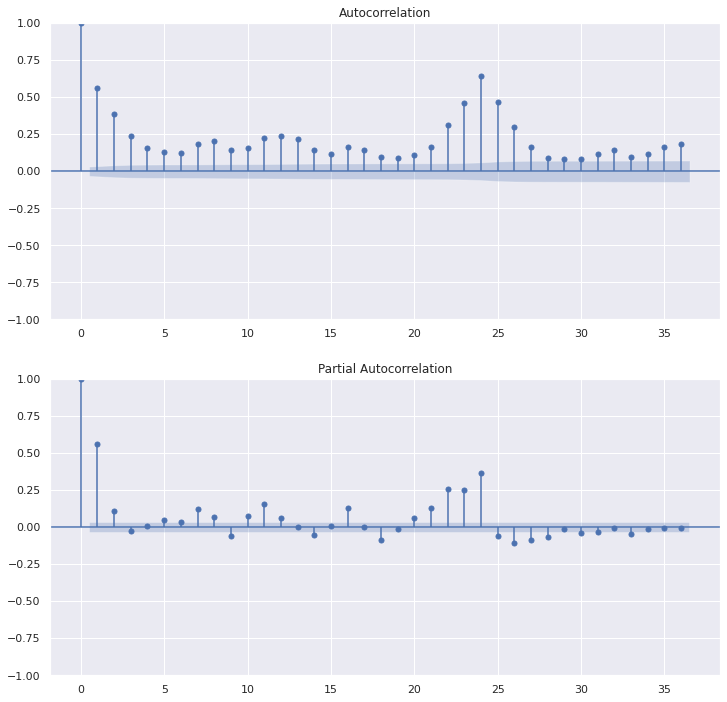

In [37]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(211)
fig = plot_acf(y_train, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y_train, ax=ax2)

По коррелограммам видно, что для $p$ имются ряд единичных корней, но наибольший коэффициент корреляции соответствует {1, 2, 3}. Для $q$ имеем {1, 2}. Построим соделми с разынми значениями параметров и посмотрим какая окажется лучше. 

Для оценки точности модели воспользуемся информационным критерием Акаике (AIC — Akaike Information Criterion). AIC оценивает, насколько хорошо модель подходит под данные. Чем меньше AIC, тем точнее модель. 

In [38]:
%%time

best_pq = (0, 0)
best_aic = np.inf

for p in range(1, 5 + 1):
    for q in [1, 2]:
        result = ARIMA(y_train, order=(p, 1, q)).fit()
        if result.aic < best_aic:
            best_pq = p, q
            best_aic = result.aic
print(f"Best params: {best_pq}, best AIC: {best_aic}")

In [39]:
result = ARIMA(y_train, order=(5, 1, 2)).fit()
result.summary()

Видно, что значимы все коэффициенты модели кроме авторегрессора 3го порядка и скользящей средней 1го.

Посмотрим диагностику модели

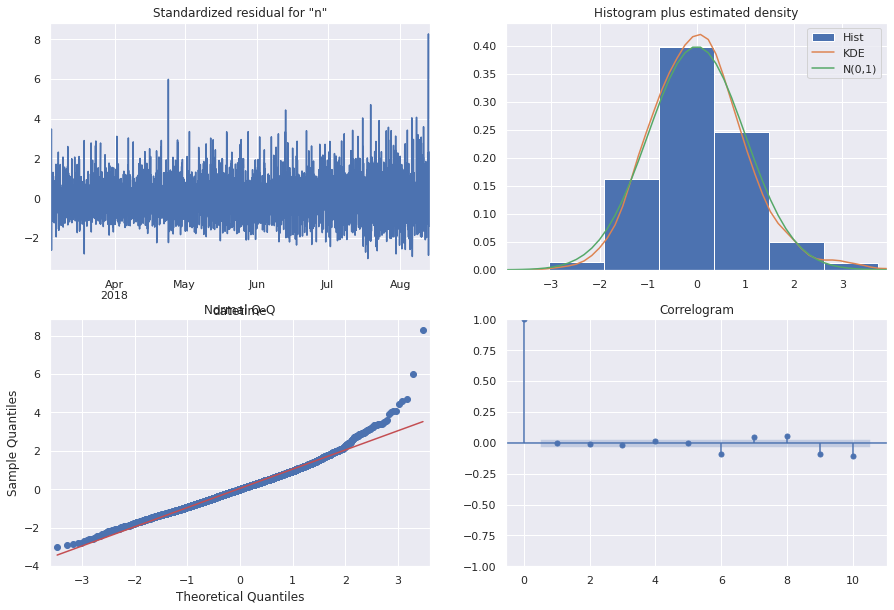

In [40]:
result.plot_diagnostics(figsize=(15, 10))
plt.show()

Видно, что остатки близки к нормальному распределению и автокорреляция не превышает 0.1

Вычислим RMSE на валидационных и тестовых данных для нашей модели-победительницы

In [41]:
arima_pred = result.get_prediction(
    start=y_test.index[0], end=y_test.index[-1], dynamic=False
).predicted_mean
print(f"RMSE of ARIMA on test: {mean_squared_error(y_test, arima_pred) ** 0.5}")

Не смотря на все наши старания просая и быстрая линейная регрессия смогла спрогнозировать временной ряд с меньшей ошибкой.

Посмотрим, как выглядит невязка наших лучших моделей на тестовой выборке

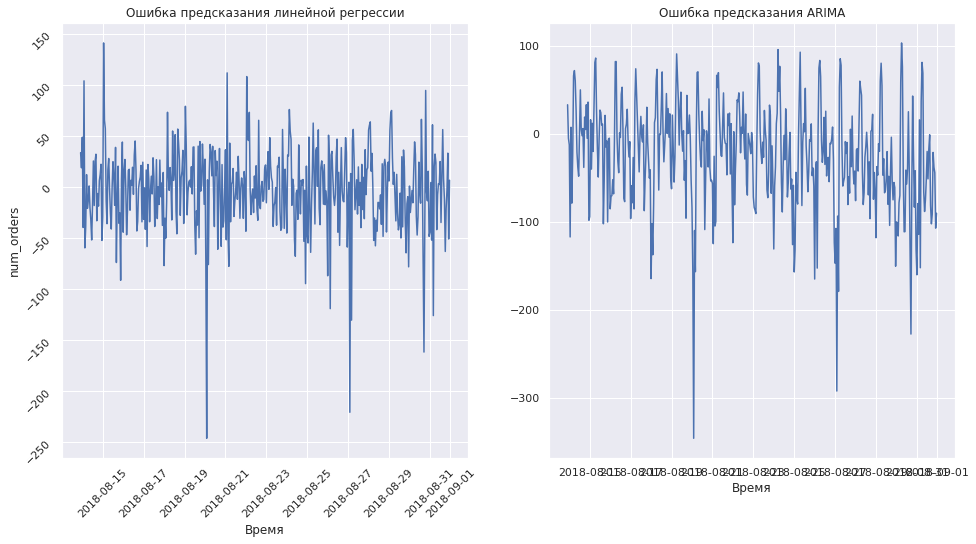

In [42]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
axes[0].tick_params(labelrotation=45)
axes[0].tick_params(labelrotation=45)
sns.lineplot(data=lr_pred - y_test, ax=axes[0]).set(
    title="Ошибка предсказания линейной регрессии", xlabel="Время"
)
sns.lineplot(data=arima_pred - y_test, ax=axes[1]).set(
    title="Ошибка предсказания ARIMA", xlabel="Время"
);

Видно, что обе модели ошибаются в меньшую сторону на одних и тех же часах. Очевидно, в на это время приходятся какие-то аномально большие количества запросов, что можель предсказать не способна. Но в целом видно, размах ошибок линейной регрессии меньше и в целом характер ошибок выглядит более хаотичным. Тогда как как ошибках ARIMA просматривается некая "сезонность", видимо она не мсогла ухватить все нюансы в обучающей последовательности.

# Выводы

Мы построили модели линейной регрессии и ARIMA, а также, для контроля качества константную модель и модель основанную на предыдущих значениях. 

И линейная регрессия и ARIMA показали точность прогноза существенно выше контрольных моделей. При этом логистическая регрессия оказалась наиболее точной.